In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [7]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [8]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

In [12]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


In [13]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

In [15]:
data.train_ds[0][0]

Text xxbos this show is one of the worst shows of xxup all xxup time ! absolutely no original jokes and they 're always a year late . like in 2009 they will finally say something about xxmaj michael xxmaj xxunk 's xxunk . all of the cast members are people who wanted to be on xxup xxunk but had to go to the lowest of the low , mad xxunk an hour of mad magazine jokes witch are n't funny to begin with , told by terrible xxmaj john xxmaj stewart wanna bees . so if you have any problem tell me i d love to hear the opinion of the 3 people who watch this show . family guy put it well " xxmaj xxunk bin xxmaj xxunk was hiding in the one place no one would look , the cast of mad xxup tv . xxmaj there is a reason why no one watches the show .

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [0]:
bs=48

In [18]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [19]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [0]:
data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"of the story could have been good , with a better effort to depict the inner feelings of a man who had to live with alcohol and violence since his youth . \n \n xxmaj sadly , the general idea seems to be more like "" i 'm the way i am because that 's the way i am "" . xxmaj and the laughingly bad attempt at giving"
1,"xxmaj samantha xxmaj morgan and xxmaj gemma xxmaj jones . xxmaj there is no comparison . xxmaj young 's vital , romantic and deeply moving version is like an exploding nova compared to xxmaj zefferelli 's wet squib . \n \n i will be interested now to see the 1970 version with xxmaj timothy xxmaj dalton , about which i 've read some very good things on this web"
2,"xxmaj save what is left of xxmaj dr. xxmaj seuss . xxmaj thank you . xxbos i saw this film a while ago on a xxmaj video xxup cd . \n \n i will 1st mention the good points . \n \n xxmaj the movie , at first , at least tries to appear that it is not biased , like not showing one character as black and"
3,"xxmaj full xxmaj moon release is stupid , senseless , has terrible acting and sound and the ( xxmaj los ) xxmaj angeles xxmaj national xxmaj forest is a poor substitute for xxmaj italy . xxmaj however , it 's pretty high on the unintentional laugh scale thanks mainly to the overwrought lead performance . xxmaj whether bug - eyed running around in cheap - looking armor brandishing a sword"
4,"this happens to be the worst movie i have ever seen in my whole life , f xxrep 5 * g visual effects , unnecessary gore and nudity ! xxmaj far apart from other xxmaj zombie movies like xxmaj night of the xxmaj living xxmaj dead and others . xxmaj there are lots of loop holes and mistakes in the movie . xxup ok if you get time after reading"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


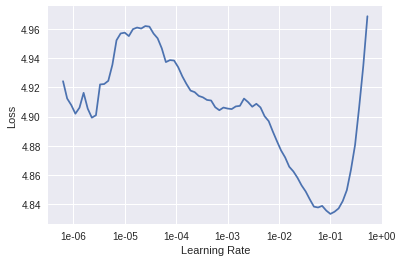

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.182325,4.058711,0.293894,1:32:20


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [1]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

NameError: ignored

In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was an example of how it seemed to be that " a single person is the person who is responsible for the fight . " The Devil 's Advocate writer David Lynch described the
I liked this movie because they felt it was similar to what Artificial Intelligence was , and in July 2011 the two website Super Audio , Hardcore Games , and The People Magazine referred to


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [34]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj this film reminds me of 42nd xxmaj street starring xxmaj bebe xxmaj daniels and xxmaj ruby xxmaj keeler . xxmaj when i watch this film a lot of it reminded me of 42nd xxmaj street , especially the character xxmaj eloise who 's a temperamental star and she ends up falling and breaks her ankle , like xxmaj bebe xxmaj daniels did in 42nd xxmaj street and another",pos
"xxbos xxmaj sometimes a film comes along that is unique . xxmaj the xxmaj nostril xxmaj picker is one such film , xxmaj the xxmaj nostril xxmaj picker is like no other film i have ever seen , unfortunately for xxmaj the xxmaj nostril xxmaj picker & myself it 's unique for different reasons than what the filmmakers had originally intended . xxmaj read on & all shall hopefully become",neg
"xxbos xxmaj as with all of xxmaj angelopoulos ' films , "" xxmaj the xxmaj suspended xxmaj step of the xxmaj stork "" implicitly demands a close and intimate participation on the part of the viewer , a fact that has certainly contributed to the limited popularity of his work . xxmaj dialogues are sparing , with no monologues or exchanges xxunk the characters ' inner conflicts , doubts ,",pos
"xxbos xxmaj sammo xxmaj hung 's 1989 film xxmaj pedicab xxmaj driver is considered by many to be his masterpiece . i have to agree to some extent as the film in its greatest parts really gets as incredible and fantastic as any xxmaj hong xxmaj kong film ever has . xxmaj it is a combination of pretty good and well written drama , interesting and sympathetic ( and also",pos


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


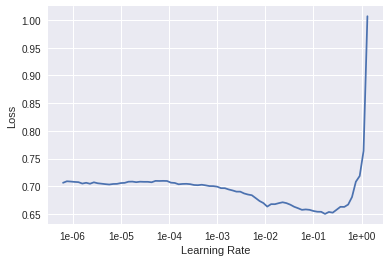

In [37]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524656,0.417945,0.807840,11:07


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.420420,0.314762,0.864160,13:52


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [49]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.365619,0.248245,0.899240,18:41


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [45]:
learn.predict("I really loved that movie, it was awesome!")

(Category neg, tensor(0), tensor([0.5099, 0.4901]))